In [1]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
from functions import *
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from synapse.ml.lightgbm import LightGBMClassifier
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
   .master("local") \
   .appName("classification") \
   .config("spark.executor.memory", "8gb") \
   .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.8") \
   .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
   .getOrCreate()

sc = spark.sparkContext

In [3]:
pvs1 = spark.read.option("header", True).option("inferSchema", True).csv('processed_data/PVS1')
pvs3 = spark.read.option("header", True).option("inferSchema", True).csv('processed_data/PVS3')
pvs7 = spark.read.option("header", True).option("inferSchema", True).csv('processed_data/PVS7')
pvs9 = spark.read.option("header", True).option("inferSchema", True).csv('processed_data/PVS9')

training_set = pvs1.union(pvs3).union(pvs7).union(pvs9)
test_set = spark.read.option("header", True).option("inferSchema", True).csv('processed_data/test_set')

In [4]:
training_set.show(5)

+--------------+-------------------+-------------------+--------------------+---------------------+---------------------+---------------------+----------------------------+----------------------------+---------------------+----------------------------+----------------------------+----------------------+----------------------+----------------------+---------------------+--------------------+---------------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+--------------------+---------------------------+---------------------------+
|road_condition|      avg_longitude|       avg_latitude|           avg_speed|avg_acc_x_dashboard_L|avg_acc_y_dashboard_L|avg_acc_z_dashboard_L|avg_acc_z_above_suspension_L|avg_acc_z_below_suspension_L|avg_acc_z_dashb

In [5]:
len(test_set.columns), len(training_set.columns)

(32, 32)

In [6]:
training_set.count(), test_set.count()

(469955, 84058)

In [7]:
training_set.show()

+--------------+-------------------+-------------------+--------------------+---------------------+---------------------+---------------------+----------------------------+----------------------------+---------------------+----------------------------+----------------------------+----------------------+----------------------+----------------------+---------------------+--------------------+---------------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+--------------------+---------------------------+---------------------------+
|road_condition|      avg_longitude|       avg_latitude|           avg_speed|avg_acc_x_dashboard_L|avg_acc_y_dashboard_L|avg_acc_z_dashboard_L|avg_acc_z_above_suspension_L|avg_acc_z_below_suspension_L|avg_acc_z_dashb

In [ ]:
feat = training_set.columns[3:]

# pipeline di preprocessing dei dati
label_index = StringIndexer(inputCol='road_condition', outputCol='label')
vectorizer = VectorAssembler(inputCols=feat, outputCol='raw_features')
scaler = StandardScaler(inputCol='raw_features', outputCol='features')

pre_classification = Pipeline(stages=[label_index, vectorizer, scaler])

In [9]:
model_pre_clas = pre_classification.fit(training_set)
proc_training_set = model_pre_clas.transform(training_set)
proc_test_set = model_pre_clas.transform(test_set)

In [ ]:
# valutatori
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
label_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="fMeasureByLabel")

In [11]:
model_indexer = model_pre_clas.stages[0]
mapping = {idx:label for idx, label in enumerate(model_indexer.labels)}
print("Labels Mapping:", mapping)

Labels Mapping: {0: 'regular', 1: 'good', 2: 'bad'}


## Logistic Regression

### Hyperparameters Tuning

In [29]:
lr = LogisticRegression(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) 
             .build())

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=accuracy_evaluator,
                          numFolds=5,
                          parallelism=4)

cv = crossval.fit(proc_training_set)

best = cv.bestModel

bestParams = best.extractParamMap()
print("Best Model Parameters:")
for param, value in bestParams.items():
    print(f"{param.name}: {value}")


Best Model Parameters:
aggregationDepth: 2
elasticNetParam: 0.0
family: auto
featuresCol: features
fitIntercept: True
labelCol: label
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 0.01
standardization: True
threshold: 0.5
tol: 1e-06


In [39]:
print(f'CrossValidation accuracy Best Configuration: {max(cv.avgMetrics)}')

CrossValidation accuracy Best Configuration: 0.8685502845503382


### Test Set Evaluation

In [53]:
predictions = best.transform(proc_test_set)

accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)


print(f'Test Set Accuracy: {accuracy}')
print(f'Test Set F1: {f1_score}')

for i in range(3):
    print(f'F1 {mapping[i]}: {label_evaluator.evaluate(predictions, {label_evaluator.metricLabel: i})}')

Test Set Accuracy: 0.420899854862119
Test Set F1: 0.32100367960084075
F1 regular: 0.3585586066887488
F1 good: 0.9274498615778016
F1 bad: 0.0006096897114861187


## Random Forest

### Hyperparameters Tuning

In [60]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [200, 400, 600, 800])
             .build())

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=accuracy_evaluator,
                          numFolds=5)

cv = crossval.fit(proc_training_set)
best = cv.bestModel

bestParams = best.extractParamMap()
print("Best Model Parameters:")
for param, value in bestParams.items():
    print(f"{param.name}: {value}")

Best Model Parameters:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: features
impurity: gini
labelCol: label
leafCol: 
maxBins: 32
maxDepth: 5
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 200
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -1524233091540120584
subsamplingRate: 1.0


In [61]:
print(f'CrossValidation accuracy Best Configuration: {max(cv.avgMetrics)}')

CrossValidation accuracy Best Configuration: 0.8657899364993156


### Test Set Evaluation

In [62]:
predictions = best.transform(proc_test_set)

accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)


print(f'Test Set Accuracy: {accuracy}')
print(f'Test Set F1: {f1_score}')

for i in range(3):
    print(f'F1 {mapping[i]}: {label_evaluator.evaluate(predictions, {label_evaluator.metricLabel: i})}')

Test Set Accuracy: 0.41195365105046516
Test Set F1: 0.29299119813600416
F1 regular: 0.3557039084786636
F1 good: 0.8291964893558301
F1 bad: 0.0


## Light Gradient Boosting Machine

### Hyperparameters Tuning

In [67]:
lgbm = LightGBMClassifier(featuresCol='features', labelCol='label', seed=8)

paramGrid = (ParamGridBuilder()
             .addGrid(lgbm.featureFraction, [0.25, 0.5, 1])
             .addGrid(lgbm.learningRate, [1])
             .addGrid(lgbm.isUnbalance, [True])
             .addGrid(lgbm.objective, ['multiclass'])
             .build())

crossval = CrossValidator(estimator=lgbm,
                          estimatorParamMaps=paramGrid,
                          evaluator=accuracy_evaluator,
                          numFolds=5,
                          parallelism=3)

cv = crossval.fit(proc_training_set)
best = cv.bestModel

bestParams = best.extractParamMap()
print("Best Model Parameters:")
for param, value in bestParams.items():
    print(f"{param.name}: {value}")

Best Model Parameters:
featuresCol: features
featuresShapCol: 
labelCol: label
leafPredictionCol: 
numIterations: -1
predictDisableShapeCheck: False
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
startIteration: 0
actualNumClasses: 3
lightGBMBooster: com.microsoft.azure.synapse.ml.lightgbm.booster.LightGBMBooster@7c44ca7d


In [ ]:
np.argmax(cv.avgMetrics), cv.extractParamMap() # learningRate 1 e numIterations 100*3 , feature fraction 1

(2,
 {Param(parent='CrossValidatorModel_834faea95574', name='seed', doc='random seed.'): -2235722677067871298,
  Param(parent='CrossValidatorModel_834faea95574', name='numFolds', doc='number of folds for cross validation'): 5,
  Param(parent='CrossValidatorModel_834faea95574', name='foldCol', doc="Param for the column name of user specified fold number. Once this is specified, :py:class:`CrossValidator` won't do random k-fold split. Note that this column should be integer type with range [0, numFolds) and Spark will throw exception on out-of-range fold numbers."): '',
  Param(parent='CrossValidatorModel_834faea95574', name='estimator', doc='estimator to be cross-validated'): LightGBMClassifier_7268955cb9f5,
  Param(parent='CrossValidatorModel_834faea95574', name='estimatorParamMaps', doc='estimator param maps'): [{Param(parent='LightGBMClassifier_7268955cb9f5', name='featureFraction', doc='Feature fraction'): 0.25,
    Param(parent='LightGBMClassifier_7268955cb9f5', name='learningRate'

In [70]:
print(f'CrossValidation accuracy Best Configuration: {max(cv.avgMetrics)}')

CrossValidation accuracy Best Configuration: 0.9778512334785374


### Test Set Evaluation

In [71]:
predictions = best.transform(proc_test_set)

accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)


print(f'Test Set Accuracy: {accuracy}')
print(f'Test Set F1: {f1_score}')

for i in range(3):
    print(f'F1 {mapping[i]}: {label_evaluator.evaluate(predictions, {label_evaluator.metricLabel: i})}')

Test Set Accuracy: 0.7510766375597802
Test Set F1: 0.7648136118344981
F1 regular: 0.554268159938076
F1 good: 0.9117912953635543
F1 bad: 0.7594158148337214


### LGBM Feature Importance

In [84]:
imp = [(name, importance) for name,importance in zip(feat,best.getFeatureImportances())]
imp = sorted(imp, key=lambda x: x[1])
imp = pd.DataFrame(imp)

[]

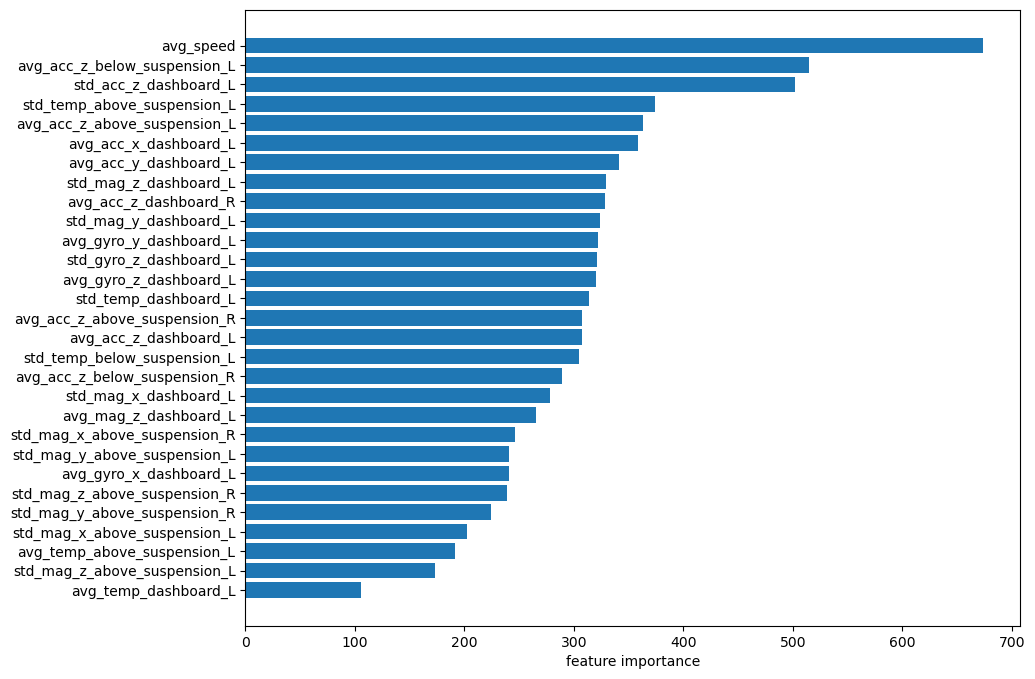

In [88]:

plt.figure(figsize=(10,8))
plt.barh(imp[0], imp[1])
plt.xlabel('feature importance')
plt.plot()